<a href="https://colab.research.google.com/github/menghsinliu/CE888-1/blob/master/Copy_of_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning from Sequences: Timeseries and Text

Created by Dr Ana Matran-Fernandez (amatra@essex.ac.uk) for CE888 (Data Science and Decision Making)

This notebook accompanies lecture 8 and illustrates recurrent neural networks on an example of a timeseries (predicting tomorrow's temperature) and a classification problem on the IMDB text dataset.

# Imports

In [42]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

In [43]:
# tensorflow imports
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Timeseries

In [44]:
df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab8/weather.csv')
df.drop(['temp_max', 'temp_min'], axis=1, inplace=True)
df

,date,radiation_avg,precip,wind_avg,wind_max,temp_avg,humidity_avg
0,14/05/2014 00:00,159,0.0,1.4,3.3,14.27,64.95
1,15/05/2014 00:00,280,0.0,0.6,2.3,13.51,72.91
2,16/05/2014 00:00,186,3.4,0.8,2.7,15.65,74.69
3,17/05/2014 00:00,221,0.0,1.0,3.3,17.46,71.42
4,18/05/2014 00:00,255,0.0,2.1,5.5,16.85,74.45
...,...,...,...,...,...,...,...
2551,17/05/2021 00:00,196,1.4,2.2,5.5,10.51,99.86
2552,17/05/2021 00:00,173,2.8,1.8,5.5,10.80,99.86
2553,18/05/2021 00:00,311,0.0,1.4,5.0,10.29,92.94
2554,19/05/2021 00:00,232,6.6,1.8,5.5,11.39,90.32


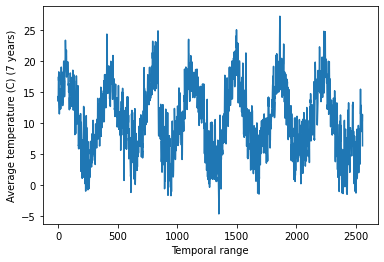

In [45]:
plt.plot(range(len(df)), df['temp_avg'])
plt.xlabel('Temporal range')
plt.ylabel('Average temperature (C) (7 years)')
plt.savefig('temperature_over_time.pdf', bbox_inches='tight')

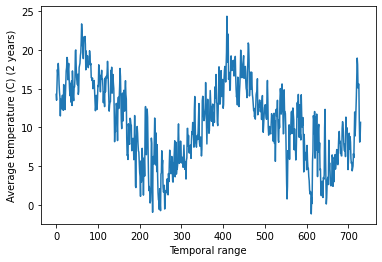

In [46]:
# Look at the first 2 years
length = 2*365
plt.plot(range(length), df['temp_avg'][:length])
plt.xlabel('Temporal range')
plt.ylabel('Average temperature (C) (2 years)')
plt.savefig('temperature_over_time_2y.pdf', bbox_inches='tight')

We have clear periodicity every year. In the previous plot we saw 7 cycles (7 years). Here we see 2.

Always look for periodicity in your timeseries. There will always be daily and yearly cycles. Check these patterns.

Another issue with timeseries is dividing the dataset into train/validation/test sets. We definitely cannot shuffle the data, and we need to be very careful with data leakage (using data from the future).

## Data prep

We'll try to predict the average temperature of tomorrow based on data from the past.

To avoid data leakage, we're going to use a simple approach: use the first 50% of data for training, the next 30% for validation, and the final 20% for testing.


In [47]:
n_tr, n_val = int(0.5*len(df)), int(0.3*len(df))
n_te = len(df) - n_tr - n_val
print('Samples for training: %d; validation: %d; test: %d' % (n_tr, n_val, n_te))

Samples for training: 1278; validation: 766; test: 512


In [48]:
# Get the data from the dataframe (dropping date column)
data = df.iloc[:, 1:].values
print(data.shape)
assert data.shape[0] == len(df)
assert data.shape[1] == len(df.columns)-1, "Are you sure you're dropping the date?"
# We need to normalise our time series. Calculate mean and std from TRAINING DATA ONLY. 
# We'll use it on the validation and test sets.
mean_tr = data[:n_tr, :].mean(axis=0)
std_tr = data[:n_tr, :].std(axis=0)
data = (data - mean_tr) / std_tr


y = df['temp_avg'].values.reshape(-1, 1)

# index of the column that contains the avg_temp
y_idx = 4

(2556, 6)


In [49]:
data[:20, y_idx] * std_tr[y_idx] + mean_tr[y_idx]

array([14.27, 13.51, 15.65, 17.46, 16.85, 18.26, 17.35, 15.55, 14.52,
       13.93, 11.48, 13.63, 12.81, 12.4 , 13.67, 14.15, 13.22, 12.21,
       15.53, 14.52])

In [50]:
y[5:25]

array([[18.26],
       [17.35],
       [15.55],
       [14.52],
       [13.93],
       [11.48],
       [13.63],
       [12.81],
       [12.4 ],
       [13.67],
       [14.15],
       [13.22],
       [12.21],
       [15.53],
       [14.52],
       [15.35],
       [12.29],
       [13.88],
       [15.13],
       [17.29]])

In [51]:
# We'll use a Dataset from keras to pass our data
sampling_rate = 1  # we keep all data points
sequence_length = 14  # 2 weeks to predict tomorrow's temperature
delay = sampling_rate * sequence_length  # the target is the day after the end of the sequence
batch_size = 16

In [52]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0, end_index=n_tr  # first 50% for training
    )

val_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr, end_index=n_tr+n_val  # 50%-80% for validation
    )

test_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr+n_val  # last 20% for test
    )

for X, target in train_dataset:
    print("X shape:", X.shape)
    print("target shape:", target.shape)
    #print(X[:, :, y_idx] * std_tr[y_idx] + mean_tr[y_idx])
    #print(target)
    break  # so we only print once

X shape: (16, 14, 6)
target shape: (16, 1)


In [53]:
# Function to plot history with neural networks
def plot_hist_regression(hist, y):
  n_ = len(hist.history['mae'])
  plt.plot(range(1, n_+1), np.asarray(hist.history['mae']), 'bo', label='MAE on training set')
  plt.plot(range(1, n_+1), np.asarray(hist.history['val_mae']), 'b', label='MAE on validation set')
  plt.legend()
  plt.xlabel("Epoch") 
  plt.ylabel("MAE (degrees)")
  plt.axhline(y=y)
  plt.show()


## Establishing a baseline


### Common sense, no ML baseline

- Sanity check
- To establish whether ML methods are actually any good

Tomorrow's temperature is likely to be close to today's: let's predict that the temperature 24 hours from now will be equal to the temperature right now.

We'll use the MAE as metric

In [54]:
def naive_method(dataset, mean, std):
    error = 0
    samples = 0
    count = 0
    for X, target in dataset:
        pred = X[:, -1, y_idx] * std + mean  # predict last available temperature and un-standardise
        #print(X.shape, target.shape, pred.shape)  # [batch_size, sequence_length, n_feats]
        #print(X[:, -1, y_idx] * std + mean, target)
        error += np.sum(np.abs(pred - target))
        samples += X.shape[0]  # batch_size
        count += 1
    return error / samples / batch_size # average


print('MAE on train set = %.2f (degrees Celsius)' % naive_method(train_dataset, mean_tr[y_idx], std_tr[y_idx]))
print('MAE on validation set = %.2f (degrees Celsius)' % naive_method(val_dataset, mean_tr[y_idx], std_tr[y_idx]))
print('MAE on test set = %.2f (degrees Celsius)' % naive_method(test_dataset, mean_tr[y_idx], std_tr[y_idx]))
# Save MAE on validation for later
baseline = naive_method(val_dataset, mean_tr[y_idx], std_tr[y_idx])

MAE on train set = 2.56 (degrees Celsius)
MAE on validation set = 2.69 (degrees Celsius)
MAE on test set = 2.85 (degrees Celsius)


This baseline achieves a validation MAE of 2.69 degrees and a test MAE of 2.85 degrees. So if we assume that tomorrow's temperature will be the same as today's, we'll be off by less than 3 degrees on average.

Not too bad, but surely we can do better!

### Simple ML baseline




In [14]:
# To get some practice with neural networks, we'll try a 1-layer NN with nothing fancy.

model_dense = models.Sequential()
model_dense.add(layers.Flatten(input_shape=(sequence_length, len(df.columns)-1)))  # we need to specify the input shape or we won't be able to see the summary
model_dense.add(layers.Dense(10, activation='relu'))
model_dense.add(layers.Dense(1))

model_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 84)                0         
                                                                 
 dense (Dense)               (None, 10)                850       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 861
Trainable params: 861
Non-trainable params: 0
_________________________________________________________________


In [19]:
n_epochs = 20

model_dense.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_dense = model_dense.fit(train_dataset, epochs=n_epochs, validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 4s 10ms/step - loss: 168.4576 - mae: 11.9113 - val_loss: 154.0942 - val_mae: 11.3336
Epoch 2/20
80/80 [==============================] - 1s 6ms/step - loss: 145.2354 - mae: 11.0600 - val_loss: 129.9911 - val_mae: 10.3887
Epoch 3/20
80/80 [==============================] - 1s 7ms/step - loss: 121.0238 - mae: 10.0947 - val_loss: 105.9347 - val_mae: 9.3822
Epoch 4/20
80/80 [==============================] - 1s 7ms/step - loss: 96.0130 - mae: 8.9880 - val_loss: 82.4721 - val_mae: 8.2889
Epoch 5/20
80/80 [==============================] - 1s 7ms/step - loss: 72.0225 - mae: 7.6966 - val_loss: 62.0341 - val_mae: 7.0547
Epoch 6/20
80/80 [==============================] - 1s 7ms/step - loss: 53.9794 - mae: 6.4555 - val_loss: 50.0863 - val_mae: 6.1320
Epoch 7/20
80/80 [==============================] - 1s 7ms/step - loss: 45.7273 - mae: 5.7541 - val_loss: 45.8424 - val_mae: 5.8232
Epoch 8/20
80/80 [==============================] - 1s 7ms/step 

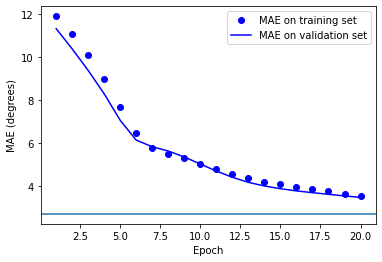

In [21]:
# Plot MAE cures for validation and training
plot_hist_regression(history_dense, baseline)

Validation loss is worse than what we had with our common-sense baseline, and we're already overfitting (MAE on training set is lower than on validation set). It turns out our previous baseline is not as easy to outperform as we thought!

Remember our 'hypothesis space'? Using 2 Dense layers doesn't seem to be very useful in this case. We need other types of layers for this problem.

In [22]:
# We know that CNNs take advantage of neighbouring values, so why don't we try that?

# In addition to the Conv2D layers we saw last week, there are Conv1D and Conv3D layers. 
# Conv1D layers rely on 1D windows that slide across an input sequence (imagine a 1D image)

model_cnn = models.Sequential()
model_cnn.add(layers.Conv1D(8, 7, activation='relu', input_shape=(sequence_length, len(df.columns)-1)))
model_cnn.add(layers.MaxPooling1D(2))
model_cnn.add(layers.Conv1D(8, 3, activation='relu'))
model_cnn.add(layers.MaxPooling1D(2))
model_cnn.add(layers.GlobalAveragePooling1D())
model_cnn.add(layers.Dense(1))

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 8)              344       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 8)             0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 8)              200       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 8)             0         
 1D)                                                             
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                      

In [23]:
model_cnn.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_cnn = model_cnn.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 9s 10ms/step - loss: 112.9509 - mae: 9.2490 - val_loss: 90.7468 - val_mae: 7.9570
Epoch 2/20
80/80 [==============================] - 1s 8ms/step - loss: 52.2145 - mae: 6.0766 - val_loss: 37.7483 - val_mae: 4.8277
Epoch 3/20
80/80 [==============================] - 1s 8ms/step - loss: 21.5184 - mae: 3.7345 - val_loss: 26.5191 - val_mae: 3.5994
Epoch 4/20
80/80 [==============================] - 1s 8ms/step - loss: 18.2716 - mae: 3.3515 - val_loss: 25.1817 - val_mae: 3.4150
Epoch 5/20
80/80 [==============================] - 1s 8ms/step - loss: 16.3954 - mae: 3.1840 - val_loss: 23.9622 - val_mae: 3.3017
Epoch 6/20
80/80 [==============================] - 1s 8ms/step - loss: 14.9298 - mae: 3.0518 - val_loss: 22.7491 - val_mae: 3.2141
Epoch 7/20
80/80 [==============================] - 1s 8ms/step - loss: 13.7637 - mae: 2.9398 - val_loss: 21.5649 - val_mae: 3.1424
Epoch 8/20
80/80 [==============================] - 1s 8ms/step - loss: 12

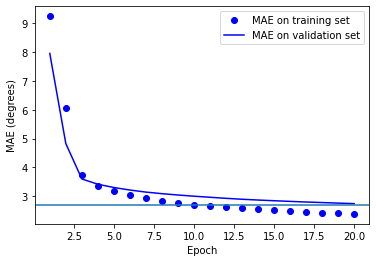

In [24]:
# Plot MAE cures for validation and training
plot_hist_regression(history_cnn, baseline)

This model isn't any better, with a validation MAE of 2.77 degrees (also worse than the 'common-sense approach' that we tried at first), and we're overfitting a bit too.

Why?

In timeseries, order matters a lot: the recent past is more informative than data from 5 days ago, and convolutional layers don't take advantage of this fact -- max pooling and global average pooling layers actually destroy this order information.

## Long Short Term Memory (LSTM) Neural Networks




In [55]:
# 1-layer LSTM

model_lstm1 = models.Sequential()
model_lstm1.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1)))
model_lstm1.add(layers.Dense(1))

model_lstm1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 20)                2160      
                                                                 
 dense_17 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


In [26]:
n_epochs = 20

In [27]:
model_lstm1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm1 = model_lstm1.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 3s 13ms/step - loss: 133.1460 - mae: 10.4461 - val_loss: 108.8654 - val_mae: 9.3583
Epoch 2/20
80/80 [==============================] - 1s 9ms/step - loss: 88.1048 - mae: 8.2658 - val_loss: 64.8812 - val_mae: 6.5865
Epoch 3/20
80/80 [==============================] - 1s 9ms/step - loss: 54.9749 - mae: 6.1364 - val_loss: 46.8314 - val_mae: 5.4221
Epoch 4/20
80/80 [==============================] - 1s 9ms/step - loss: 40.8582 - mae: 5.2137 - val_loss: 36.7499 - val_mae: 4.7922
Epoch 5/20
80/80 [==============================] - 1s 9ms/step - loss: 31.8333 - mae: 4.5680 - val_loss: 29.7674 - val_mae: 4.3316
Epoch 6/20
80/80 [==============================] - 1s 9ms/step - loss: 25.5471 - mae: 4.0889 - val_loss: 24.7435 - val_mae: 3.9738
Epoch 7/20
80/80 [==============================] - 1s 9ms/step - loss: 20.8905 - mae: 3.6991 - val_loss: 20.9609 - val_mae: 3.6653
Epoch 8/20
80/80 [==============================] - 1s 9ms/step - loss: 

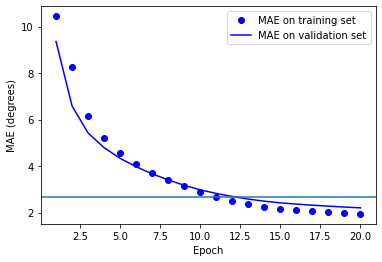

In [28]:
# Plot MAE cures for validation and training
plot_hist_regression(history_lstm1, baseline)


In [29]:
print('Test MAE = %.2f degrees' % model_lstm1.evaluate(test_dataset)[1])

31/31 [==============================] - 0s 4ms/step - loss: 8.4855 - mae: 2.2958
Test MAE = 2.30 degrees


Success! We finally beat the common-sense baseline! The validation MAE now is 2.12 degrees, and the test MAE is 2.27.

Why do LSTM layers work? Let's go back to the slides

In [30]:
# Adding dropout

model_lstm2 = models.Sequential()
model_lstm2.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25))
model_lstm2.add(layers.Dropout(0.4))
model_lstm2.add(layers.Dense(1))

model_lstm2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                2160      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_lstm2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm2 = model_lstm2.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 7s 57ms/step - loss: 137.8120 - mae: 10.6335 - val_loss: 116.4776 - val_mae: 9.6602
Epoch 2/20
80/80 [==============================] - 4s 53ms/step - loss: 93.2523 - mae: 8.5515 - val_loss: 65.6410 - val_mae: 6.7214
Epoch 3/20
80/80 [==============================] - 4s 54ms/step - loss: 55.6675 - mae: 6.1743 - val_loss: 44.1061 - val_mae: 5.2180
Epoch 4/20
80/80 [==============================] - 4s 54ms/step - loss: 41.3026 - mae: 5.2399 - val_loss: 33.9953 - val_mae: 4.5733
Epoch 5/20
80/80 [==============================] - 4s 53ms/step - loss: 32.2636 - mae: 4.5837 - val_loss: 27.7267 - val_mae: 4.1514
Epoch 6/20
80/80 [==============================] - 4s 53ms/step - loss: 27.2317 - mae: 4.2085 - val_loss: 23.5875 - val_mae: 3.8475
Epoch 7/20
80/80 [==============================] - 4s 53ms/step - loss: 24.2817 - mae: 3.9554 - val_loss: 20.0217 - val_mae: 3.5355
Epoch 8/20
80/80 [==============================] - 4s 53ms/step -

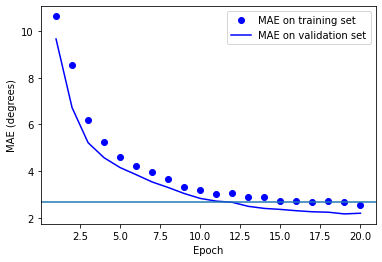

In [32]:
# Plot MAE cures for validation and training
plot_hist_regression(history_lstm2, baseline)

In [33]:
print('Test MAE = %.2f degrees' % model_lstm2.evaluate(test_dataset)[1])

31/31 [==============================] - 0s 8ms/step - loss: 7.9916 - mae: 2.1984
Test MAE = 2.20 degrees


Note that validation set MAE is now lower than MAE on training set -- no longer overfitting. Validation MAE is 2.16 and test MAE is also 2.16.

NOTE: This is a very simple dataset with very small differences in performance between different models.  You'll just have to take my word for it that *in general* this approach works. 

In [56]:
# Performance in the previous figure can (maybe) still be improved
# Let's try to add some more layers -- we can do this now that we're no longer overfitting

model_lstm3 = models.Sequential()
model_lstm3.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25, return_sequences=True))  # NEW!
model_lstm3.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25))  # NEW!!
model_lstm3.add(layers.Dropout(0.4))
model_lstm3.add(layers.Dense(1))
model_lstm3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 14, 20)            2160      
                                                                 
 lstm_12 (LSTM)              (None, 20)                3280      
                                                                 
 dropout_14 (Dropout)        (None, 20)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 21        
                                                                 
Total params: 5,461
Trainable params: 5,461
Non-trainable params: 0
_________________________________________________________________


In [57]:
model_lstm3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

callbacks = [EarlyStopping(monitor='val_mae', patience=2)]

history_lstm3 = model_lstm3.fit(train_dataset, epochs=60,  # increased number of epochs
                            validation_data=val_dataset,
                            callbacks=callbacks)  # but added early stopping callback


Epoch 1/60
80/80 [==============================] - ETA: 0s - loss: 113.3809 - mae: 9.5298

KeyboardInterrupt: ignored

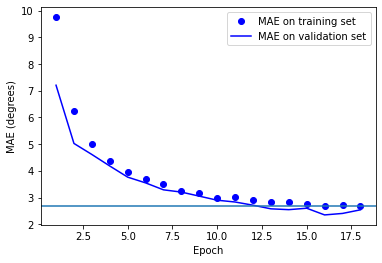

31/31 [==============================] - 0s 12ms/step - loss: 9.9231 - mae: 2.4946
Test MAE = 2.49 degrees


In [36]:
# Plot MAE cures for validation and training
plot_hist_regression(history_lstm3, baseline)
print('Test MAE = %.2f degrees' % model_lstm3.evaluate(test_dataset)[1])

Validation MAE = 1.92 degrees

Test MAE = 1.89 degrees


# Text

## Data prep

We'll try to predict whether the review for a movie is positive or negative looking only at the text of the review.

We'll use the IMDB text dataset for this task, which is available on `keras.datasets` and described [here](https://keras.io/api/datasets/imdb/). 

We'll merge the training and test sets and use 60% for training, 20% for validation, and 20% for testing.


As this is a binary classificationp problem, we'll use the binary cross entropy loss function. We will keep track of accuracy when training and evaluating the model.


In [58]:
def plot_hist_classif(hist):
  n_ = len(hist.history['accuracy'])
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['accuracy']), 'bo', label='Accuracy on training set')
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['val_accuracy']), 'b', label='Accuracy on validation set')
  plt.legend()
  plt.xlabel("Epoch") 
  plt.ylabel("Accuracy")
  plt.ylim(0, 100)
  plt.axhline(y=50)
  plt.show()


In [59]:
max_features = 15000  # only consider the top 15k words
maxlen = 500  # first 500 words of each review
batch_size = 32

print('Loading data...')
# Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences', x_train.shape)
print(len(x_test), 'test sequences', x_test.shape)

Loading data...
25000 train sequences (25000,)
25000 test sequences (25000,)


In [60]:
# How balanced is this dataset?
print(np.sum(y_train)/len(y_train))
print(np.sum(y_test)/len(y_test))

0.5
0.5


In [61]:
# Merge the two datasets and divide: 60% for training, 20% validation, 20% test
x_, y_ = np.concatenate((x_train, x_test)), np.concatenate((y_train, y_test))
print(x_.shape, y_.shape)
x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.4, random_state=10)  # 60/40 split
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)  # 50/50 split
print(len(x_train), 'train sequences', x_train.shape)
print(len(x_val), 'validation sequences', x_val.shape)
print(len(x_test), 'test sequences', x_test.shape)

(50000,) (50000,)
30000 train sequences (30000,)
10000 validation sequences (10000,)
10000 test sequences (10000,)


In [62]:
x_train[0][:10]  # numbers!!

[1, 11531, 186, 8, 28, 6, 6482, 7, 269, 4042]

In [63]:
# We can explore what one of the reviews looks like at this point.

# Retrieve the word index file that maps words to indices
word_index = keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words (which is what we have)
inverted_word_index = dict((i, word) for (word, i) in word_index.items())
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])
decoded_sequence

"the lilly horror in one is fatale br looks meaningless in bronson be showing as you debut film ample to and ingredients zombi ample they for series and thought she's all manipulate and believing in j show look early last quote desire tight interesting that's kind out is far shelter but of frame br and"

In [64]:
# Let's ensure all sequences have the same length through padding
# - shorter reviews are padded with 0's
# - longer reviews are cut
print('Pad sequences')
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)

Pad sequences
x_train shape: (30000, 500)
x_val shape: (10000, 500)
x_test shape: (10000, 500)


In [65]:
# Basic feedforward model
model = models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 500, 128)          1920000   
                                                                 
 dense_19 (Dense)            (None, 500, 64)           8256      
                                                                 
 dropout_15 (Dropout)        (None, 500, 64)           0         
                                                                 
 dense_20 (Dense)            (None, 500, 64)           4160      
                                                                 
 dropout_16 (Dropout)        (None, 500, 64)           0         
                                                                 
 flatten_2 (Flatten)         (None, 32000)             0         
                                                                 
 dense_21 (Dense)            (None, 1)               

In [66]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
934/938 [============================>.] - ETA: 0s - loss: 0.4518 - accuracy: 0.7567

KeyboardInterrupt: ignored

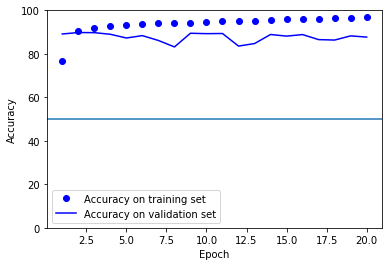

313/313 [==============================] - 1s 3ms/step - loss: 0.4015 - accuracy: 0.8765
Test Accuracy = 0.88


In [46]:
plot_hist_classif(history)
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])  # overfitting!

In [26]:
# Let's try an RNN
model = models.Sequential()
model.add(layers.Embedding(max_features, 64))
model.add(layers.LSTM(128, return_sequences=False))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          960000    
                                                                 
 lstm_3 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,058,945
Trainable params: 1,058,945
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
938/938 [==============================] - 31s 30ms/step - loss: 0.4250 - accuracy: 0.8106 - val_loss: 0.3544 - val_accuracy: 0.8497
Epoch 2/20
938/938 [==============================] - 26s 28ms/step - loss: 0.2828 - accuracy: 0.8911 - val_loss: 0.3076 - val_accuracy: 0.8622
Epoch 3/20
938/938 [==============================] - 29s 31ms/step - loss: 0.2396 - accuracy: 0.9106 - val_loss: 0.2705 - val_accuracy: 0.8866
Epoch 4/20
938/938 [==============================] - 26s 28ms/step - loss: 0.2127 - accuracy: 0.9221 - val_loss: 0.3035 - val_accuracy: 0.8934
Epoch 5/20
938/938 [==============================] - 26s 28ms/step - loss: 0.1861 - accuracy: 0.9328 - val_loss: 0.2526 - val_accuracy: 0.9056
Epoch 6/20
938/938 [==============================] - 29s 30ms/step - loss: 0.1689 - accuracy: 0.9405 - val_loss: 0.2716 - val_accuracy: 0.8870
Epoch 7/20
938/938 [==============================] - 26s 28ms/step - loss: 0.1490 - accuracy: 0.9483 - val_loss: 0.2520 - val_accuracy:

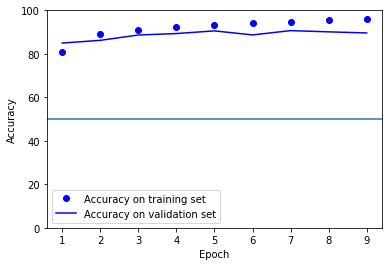

313/313 [==============================] - 3s 11ms/step - loss: 0.3383 - accuracy: 0.9032
Test Accuracy = 0.90


In [27]:
# This model will take a long time to train, so we add an early stopping criterion
# N.B: It's actually much faster to train WITHOUT A GPU!!
callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)]
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=20, validation_data=(x_val, y_val), callbacks=callbacks)
plot_hist_classif(history)
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])
# Note that we're still overfitting, but this is just an example of use

## Your turn!

Implement a bidirectional RNN that can outperform the LSTM model we had above.

A starting skeleton could be:
 
*   Embedding layer with an output dimension of 64
*   Bidirectional layer with a 32-neuron LSTM layer
*   Dense layer with 1 neuron and a sigmoid activation

Some suggestions:

- Change the sizes of the layers (i.e., the numbers of neurons)
- Add dropout
- Add other recurrent and/or bidirectional layers

Once you have a model that scores over 90% on the validation set, check its performance on the test set and upload it on the code checker in Moodle.

Note that the model I'm suggesting above will be able to reach the desired performance, but it will show signs of overfitting. Can you do it by adding regularization (dropout, smaller network) so you don't overfit?


In [78]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, None, 64)          960000    
                                                                 
 bidirectional_15 (Bidirecti  (None, None, 64)         24832     
 onal)                                                           
                                                                 
 dropout_40 (Dropout)        (None, None, 64)          0         
                                                                 
 bidirectional_16 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dense_41 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,009,729
Trainable params: 1,009,729
N

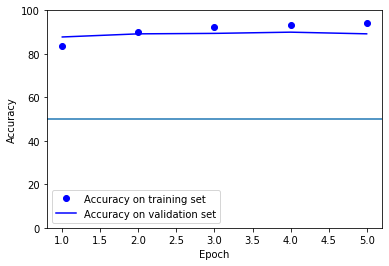

313/313 [==============================] - 11s 28ms/step - loss: 0.2539 - accuracy: 0.9008
Test Accuracy = 0.90


In [102]:
n_ = 5  # number of epochs. You can edit this

model = models.Sequential()
# YOUR CODE HERE!
model.add(layers.Embedding(max_features, 64))
model.add(layers.Bidirectional(LSTM(32, return_sequences=True)))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(LSTM(32, return_sequences=False)))
#model.add(layers.LSTM(64, return_sequences=False))
#model.add((Dense(1, activation='sigmoid')))
model.add(layers.Dense(1, activation="sigmoid"))
# I DON'T RECOMMEND THAT YOU CHANGE CODE AFTER THIS POINT
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

print(model.summary())

# This model will take a long time to train, so we add an early stopping criterion
# I've also added a ModelCheckpoint that will save the best model according to val_accuracy regardless of whether we continue training
callbacks = [EarlyStopping(monitor='val_accuracy', patience=1),
             ModelCheckpoint("model.keras", save_best_only=True, monitor="val_accuracy", mode='max')]

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_, 
                    validation_data=(x_val, y_val), 
                    callbacks=callbacks)
plot_hist_classif(history)
model = keras.models.load_model("model.keras")
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])

In [106]:
if model.count_params() > 1000000:
    print("Due to memory constraints on Moodle, the lab quiz has a 10MB limit on your model size, so you need to use a smaller model to validate through the auto-marker.")

if history.history["val_accuracy"][-1] > 0.85:
    print("Your model is accurate enough!")

else:
    print("Accuracy is below the threshold!")
    raise Exception("Your model isn't accurate enough to pass the progress checker!")
# Save the model into a local folder
keras.models.save_model(model, "Model.h5",save_format='h5')
print('Model saved! You can now upload it to the lab quiz.')

Due to memory constraints on Moodle, the lab quiz has a 10MB limit on your model size, so you need to use a smaller model to validate through the auto-marker.
Your model is accurate enough!
Model saved! You can now upload it to the lab quiz.
